In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

# UTILIETIES

The main idea is to train two basic classifier in order gain the performance of that, perform some dimensionality reduction and imbalance learing task on it, and evaluate the difference in performance.

In [ ]:

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, \
    PrecisionRecallDisplay, RocCurveDisplay, accuracy_score

In [ ]:
# we use the dataset without duplicated columns

X_train = pd.read_csv('X_train_no_red.csv', header = 0)
y_train = pd.read_fwf('y_train.txt', header = None)
X_test = pd.read_csv('X_test_no_red.csv', header = 0)
y_test = pd.read_fwf('y_test.txt', header = None)

In [ ]:
#X_train.columns = X_train.columns.astype(int)
#y_train.columns = y_train.columns.astype(int)
#X_test.columns = X_test.columns.astype(int)

In [ ]:
with open("features.txt") as f:
    lines = f.read().splitlines() 

In [ ]:
features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name

In [ ]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

In [ ]:
activities

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [ ]:
features

{0: 'tBodyAcc-mean()-X',
 1: 'tBodyAcc-mean()-Y',
 2: 'tBodyAcc-mean()-Z',
 3: 'tBodyAcc-std()-X',
 4: 'tBodyAcc-std()-Y',
 5: 'tBodyAcc-std()-Z',
 6: 'tBodyAcc-mad()-X',
 7: 'tBodyAcc-mad()-Y',
 8: 'tBodyAcc-mad()-Z',
 9: 'tBodyAcc-max()-X',
 10: 'tBodyAcc-max()-Y',
 11: 'tBodyAcc-max()-Z',
 12: 'tBodyAcc-min()-X',
 13: 'tBodyAcc-min()-Y',
 14: 'tBodyAcc-min()-Z',
 15: 'tBodyAcc-sma()',
 16: 'tBodyAcc-energy()-X',
 17: 'tBodyAcc-energy()-Y',
 18: 'tBodyAcc-energy()-Z',
 19: 'tBodyAcc-iqr()-X',
 20: 'tBodyAcc-iqr()-Y',
 21: 'tBodyAcc-iqr()-Z',
 22: 'tBodyAcc-entropy()-X',
 23: 'tBodyAcc-entropy()-Y',
 24: 'tBodyAcc-entropy()-Z',
 25: 'tBodyAcc-arCoeff()-X,1',
 26: 'tBodyAcc-arCoeff()-X,2',
 27: 'tBodyAcc-arCoeff()-X,3',
 28: 'tBodyAcc-arCoeff()-X,4',
 29: 'tBodyAcc-arCoeff()-Y,1',
 30: 'tBodyAcc-arCoeff()-Y,2',
 31: 'tBodyAcc-arCoeff()-Y,3',
 32: 'tBodyAcc-arCoeff()-Y,4',
 33: 'tBodyAcc-arCoeff()-Z,1',
 34: 'tBodyAcc-arCoeff()-Z,2',
 35: 'tBodyAcc-arCoeff()-Z,3',
 36: 'tBodyAcc-arCoeff

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline

from itertools import accumulate

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, \
    f1_score, make_scorer, PrecisionRecallDisplay, RocCurveDisplay

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, \
    RandomOverSampler as ROS
from imblearn.under_sampling import RandomUnderSampler as RUS, \
    CondensedNearestNeighbour as CNN, TomekLinks, \
    EditedNearestNeighbours as ENN

from scipy.spatial.distance import pdist, squareform

import sys
import joblib
import six
import sklearn.ensemble._base
sys.modules['sklearn.externals.joblib'] = joblib
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.six.moves'] = six.moves
sys.modules['sklearn.ensemble.base'] = sklearn.ensemble._base


In [ ]:
def plot_confusion_mtx(cm: 'confusion matrix', labels = None, 
                       figsize = (3,3), binary = True):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16}, 
                cmap = "Blues", cbar = False, ax = ax)
    ax.set_xlabel('Predicted Class', fontsize = 14)
    ax.set_ylabel('Actual Class', fontsize = 14)
    if labels is None:
        labels = range(1, cm.shape[1] + 1)     
    ax.set_xticks(ax.get_xticks(), labels)
    ax.set_yticks(ax.get_yticks(), labels)
    if binary:
        ax.set_xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.set_yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

In [ ]:
def plot_gains_curve(y_true:'np array', y_pred_proba:'np array', 
                     label = None, baseline = False):
    idx = np.argsort(y_pred_proba)[::-1]
    acc = list(accumulate(y_true[idx]))
    plt.plot(acc, label = label)
    n_samples = len(acc)
    if baseline:
        plt.plot([0,n_samples], [0, acc[-1]], 'k--')
    
    xticks = np.linspace(0, n_samples, 6)
    yticks = np.linspace(0, acc[-1], 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1) 
    y_lab = np.around(np.linspace(0, 1, 6), decimals = 1) 
    plt.xticks(xticks, x_lab)
    plt.yticks(yticks, y_lab)
    plt.xlabel('% of samples', fontsize = 14)
    plt.ylabel('Gain', fontsize = 14)

In [ ]:
def plot_lift(y_true:'np array', y_pred_proba:'np array', 
              label = None, baseline = False):
    n_samples = len(y_true)
    idx = np.argsort(y_pred_proba)[::-1]
    cum_trues = list(accumulate(y_true[idx]))
    perc_trues = map(lambda x: x / cum_trues[-1], cum_trues)   
    cum_samples = range(1, n_samples + 1)
    perc_samples = map(lambda x: x / n_samples, cum_samples)  
    lift = list(map(lambda x, y: x / y, perc_trues, perc_samples))    
    plt.plot(lift, label = label)
    if baseline:
        plt.axhline(y = 1, ls = '--', color = 'k')
    plt.xlabel('% of samples', fontsize = 14)
    plt.ylabel('Lift', fontsize = 14)

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report


In [97]:
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")
    print(roc_auc_score(y_test, y_score[:,1]))

    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()

    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()


    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()


    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")
    plot_lift_curve(y_test, y_score)
    plt.show()

In [98]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [99]:
# - y_true: target reale
# - y_pred: target predetto dal classificatore
# stampa: matrice di confusione, accuracy, precision, recall, specificity, F1
def result_pred(y_true, y_pred):
    #print("**** Matrice di Confusione *****")
    #tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #print(' True negative: %d False negative: %d' % (tn, fn))
    #print(' True positive: %d False positive: %d' % (tp, fp))
    #print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred, False)
    print("Numero di campioni correttamente correlati: ", accuracy)
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)
    print("____________________________________________")

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")

    # Calcolo della specificity
    #print("**** Calcolo della specificity *****")
    #specificity = tn / (tn+fp)
    #print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")

    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall,
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")

    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))

    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression

#Funzione per plottare
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def plot_decision_knn(X, y):

    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    estimator = KNeighborsClassifier(n_neighbors=5)
    title = "Learning Curves KNN "
    plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                        cv=cv, n_jobs=10)

    # SVC is more expensive so we do a lower number of CV iterations:
    cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    estimator = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1000, min_samples_leaf=5, min_samples_split=50)
    title = "Learning Curves DecisionTree"
    plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                        cv=cv, n_jobs=10)

    plt.show()

In [101]:
from sklearn.manifold import PCA
pca = TSNE(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

ImportError: cannot import name 'PCA' from 'sklearn.manifold' (C:\Users\Dell\anaconda3\lib\site-packages\sklearn\manifold\__init__.py)

# DECISION TREE

In [102]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 15, min_samples_leaf = 1, min_samples_split = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuratezza: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test, y_pred, 
      target_names = activities.values()))

Accuratezza: 85.88%
                    precision    recall  f1-score   support

           WALKING       0.82      0.92      0.87       496
  WALKING_UPSTAIRS       0.82      0.75      0.78       471
WALKING_DOWNSTAIRS       0.87      0.85      0.86       420
           SITTING       0.84      0.76      0.80       491
          STANDING       0.80      0.86      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.86      2947
         macro avg       0.86      0.86      0.86      2947
      weighted avg       0.86      0.86      0.86      2947



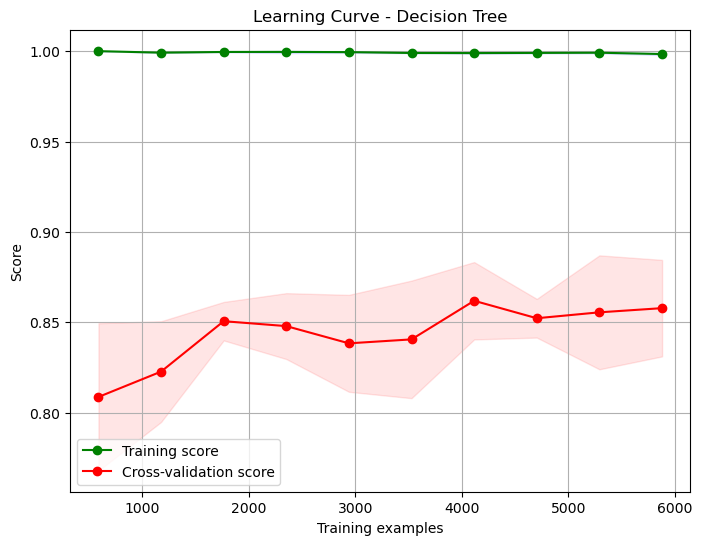

In [57]:
from sklearn.model_selection import learning_curve
# Calcola la learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcola le medie e gli errori standard delle prestazioni
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotta la learning curve
plt.figure(figsize=(8, 6))
plt.title('Learning Curve - Decision Tree')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='b')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color='r')
plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
         label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
         label='Cross-validation score')
plt.legend(loc='best')
plt.show()

In [104]:
def plot_decision_boundaries(X_train, classes, clf, 
                             class_names: dict = None, figsize = (6, 4))

SyntaxError: invalid syntax (1613098915.py, line 2)

In [105]:
from sklearn import tree
from sklearn.metrics import classification_report

In [23]:

from sklearn.model_selection import GridSearchCV



# Set the parameters by cross-validation
tuned_parameters = {
    'criterion' : ['gini'],
    'max_depth': [2, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}

#scores = ['recall', 'f1']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    obj = tree.DecisionTreeClassifier()

    #if (score == "recall"):
    clf = GridSearchCV(obj, tuned_parameters, cv=5, scoring=score)
    #else:
    #  clf = GridSearchCV(obj, tuned_parameters, cv=5, scoring='%s_macro' % score)

    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    #print("**** Matrice di Confusione *****")
    #tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #print(' True negative: %d False negative: %d' % (tn, fn))
    #print(' True positive: %d False positive: %d' % (tp, fp))
    #print("____________________________________________")

# Tuning hyper-parameters for ----> f1



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "

Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

Grid scores on development set:

nan (+/-nan) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 5}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 2}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 5}
nan (+/-nan) f

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no p

In [26]:
clf = tree.DecisionTreeClassifier()

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()

print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, 
      target_names = activities.values()))


Best parameters set found on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                    precision    recall  f1-score   support

           WALKING       0.82      0.87      0.84       496
  WALKING_UPSTAIRS       0.79      0.76      0.77       471
WALKING_DOWNSTAIRS       0.85      0.83      0.84       420
           SITTING       0.84      0.77      0.80       491
          STANDING       0.80      0.86      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.85      2947
         macro avg       0.85      0.85      0.85      2947
      weighted avg       0.85      0.85      0.85      2947



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


The following script is just a duplicate of the previous one. It was useful in the training spot.

In [106]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 15, min_samples_leaf = 1, min_samples_split = 5)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, 
      target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.82      0.92      0.87       496
  WALKING_UPSTAIRS       0.83      0.73      0.78       471
WALKING_DOWNSTAIRS       0.84      0.83      0.83       420
           SITTING       0.82      0.76      0.79       491
          STANDING       0.79      0.84      0.82       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.85      2947
         macro avg       0.85      0.85      0.85      2947
      weighted avg       0.85      0.85      0.85      2947



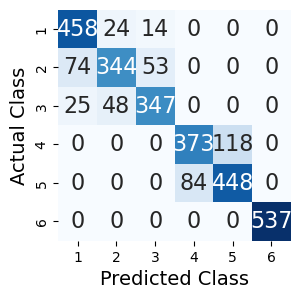

In [107]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
plot_confusion_mtx(cm, binary = False)

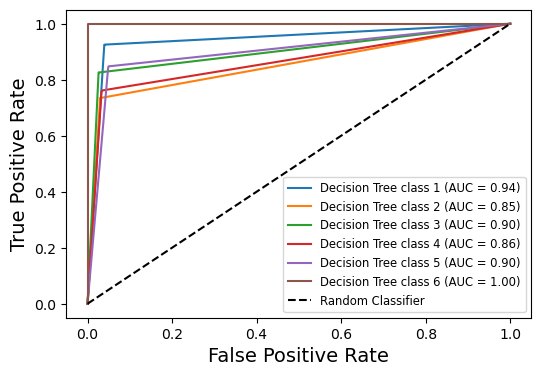

In [108]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
plot_multiclass_roc(clf, X_test, y_test, 
                    'Decision Tree ', ax = ax)
ax.legend(fontsize = 'small')
plt.savefig('log_multiclass_roc.pdf', bbox_inches = 'tight')
plt.show()

# k-NEAREST NEIGHBOUR


In [32]:
# Grid search vera e propria
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

parameters = {'n_neighbors': np.arange(1, 39), 'weights':['uniform', 'distance'], 'p':[1,2,3]}

scores = ['f1']
k_fold = StratifiedKFold(n_splits=4)

estimator_list = []
grid_list = []
result_list = []
best_params = []


knn = KNN(n_jobs = -1)
#for score in scores.values():
error = []
search = GridSearchCV(knn, parameters, error_score='raise', cv=k_fold)
#search = GridSearchCV(knn, parameters, scoring=score, error_score='raise', cv=k_fold)
search.fit(X_train, y_train)
grid_list.append(search)
#print(search.cv_results_)
clf = search.best_estimator_
estimator_list.append(clf)
result_list.append(search.cv_results_)
best_params.append(search.best_params_)
print(clf)
print("_____________________________________________")
print("Best parameters set found on development set:")
print()
print(search.best_params_)
print()
print("Grid scores on development set:")
print()
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
y_true, y_pred = y_test, search.predict(X_test)
print("STAMPIAMO LA MEDIA ERRORE: ")
print(np.mean(y_pred != y_true))
    #plt.figure(figsize=(12, 6))
    #range(1, 40),
    #plt.plot(np.arange(0, len(y_true)), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue')#, markersize=10)
    #plt.title('Error Rate K Value')
    #plt.xlabel('K Value')
    #plt.ylabel('Mean Error')
    #plt.grid()
    #plt.show()
print("_____________________________________________")
print(classification_report(y_true, y_pred, target_names=activities.values()))
print()
print("_____________________________________________")
print("_____________________________________________")
print(confusion_matrix(y_true, y_pred))
print()
print("_____________________________________________")

In [111]:
from sklearn.decomposition import PCA

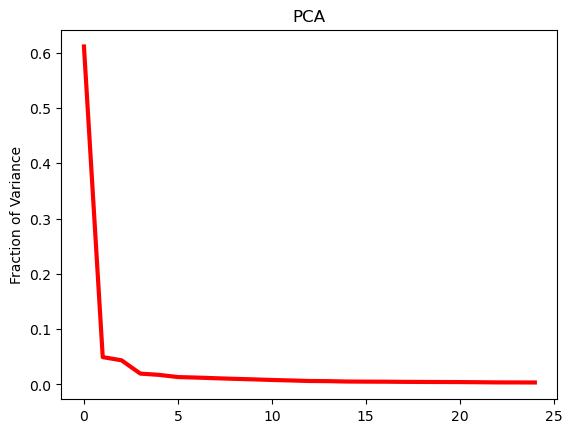

In [113]:
plt.plot(PCA(n_components=25).fit(X_train).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

In [114]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [115]:
X_train_pca.shape

(7352, 3)

In [116]:
X_test_pca = pca.transform(X_test)

clf =  KNN(n_jobs = -1)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7122497455039023
F1-score [0.65945046 0.76886792 0.50274725 0.59934138 0.69001751 0.9906015 ]
              precision    recall  f1-score   support

           1       0.56      0.80      0.66       496
           2       0.86      0.69      0.77       471
           3       0.59      0.44      0.50       420
           4       0.65      0.56      0.60       491
           5       0.65      0.74      0.69       532
           6       1.00      0.98      0.99       537

    accuracy                           0.71      2947
   macro avg       0.72      0.70      0.70      2947
weighted avg       0.72      0.71      0.71      2947



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


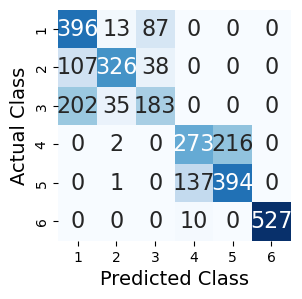

In [117]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
plot_confusion_mtx(cm, binary = False)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

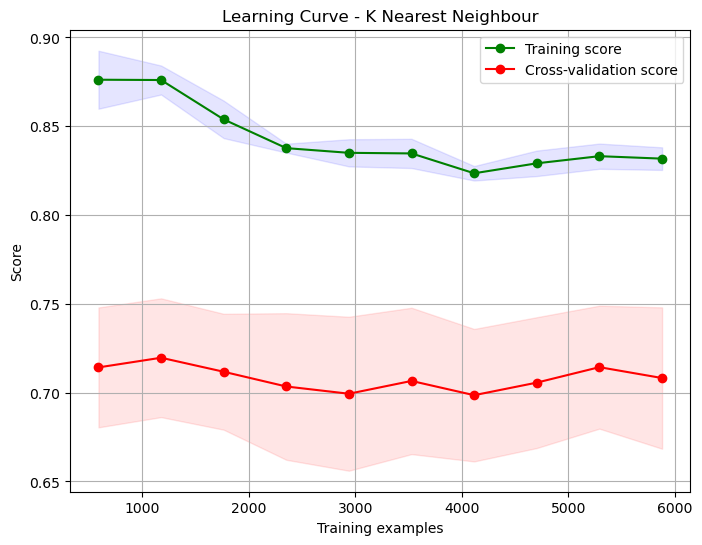

In [119]:
from sklearn.model_selection import learning_curve
# Calcola la learning curve
train_sizes, train_scores, test_scores = learning_curve(
    knn, X_train_pca, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcola le medie e gli errori standard delle prestazioni
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotta la learning curve
plt.figure(figsize=(8, 6))
plt.title('Learning Curve - K Nearest Neighbour')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='b')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color='r')
plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
         label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
         label='Cross-validation score')
plt.legend(loc='best')
plt.show()

# LOGISTIC REGRESSION

In [71]:
logReg = LogisticRegression(random_state=0)
logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logReg.score(X_test, y_test)))
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, target_names=activities.values()))



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression classifier on test set: 0.96
Accuracy 0.9582626399728538
F1-score [0.96551724 0.95268817 0.97115385 0.92209178 0.93670886 1.        ]
                    precision    recall  f1-score   support

           WALKING       0.94      0.99      0.97       496
  WALKING_UPSTAIRS       0.97      0.94      0.95       471
WALKING_DOWNSTAIRS       0.98      0.96      0.97       420
           SITTING       0.97      0.88      0.92       491
          STANDING       0.90      0.97      0.94       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
clf = LogisticRegression(random_state=0, C=10, penalty="l2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, target_names=activities.values()))

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy 0.9565659993213438
F1-score [0.95944609 0.95268817 0.96766467 0.92209178 0.93586269 1.        ]
              precision    recall  f1-score   support

           1       0.94      0.98      0.96       496
           2       0.97      0.94      0.95       471
           3       0.97      0.96      0.97       420
           4       0.97      0.88      0.92       491
           5       0.90      0.97      0.94       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


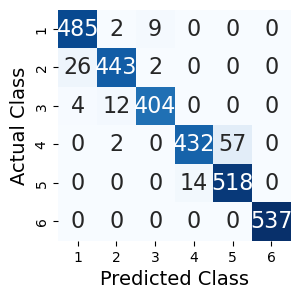

In [60]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
plot_confusion_mtx(cm, binary = False)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

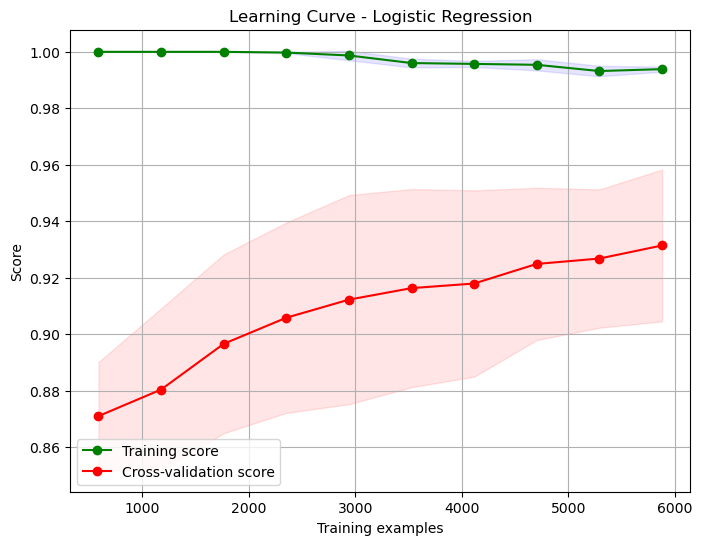

In [58]:
from sklearn.model_selection import learning_curve
# Calcola la learning curve
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcola le medie e gli errori standard delle prestazioni
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotta la learning curve
plt.figure(figsize=(8, 6))
plt.title('Learning Curve - Logistic Regression')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='b')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color='r')
plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
         label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
         label='Cross-validation score')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, PrecisionRecallDisplay, RocCurveDisplay, accuracy_score


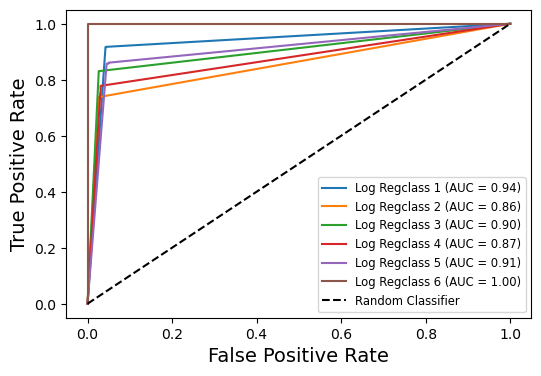

In [72]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
plot_multiclass_roc(clf, X_test, y_test, 
                    'Log Reg', ax = ax)
ax.legend(fontsize = 'small')
plt.savefig('log_multiclass_roc.pdf', bbox_inches = 'tight')
plt.show()

AVENDO PROVATO KNN CON PCA E NOTANDO CHE FUNZIONA, PROVO ANCHE LOGISTIC E DECISION TREE

In [126]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [127]:
X_train_pca.shape

(7352, 3)

In [128]:
X_test_pca = pca.transform(X_test)

In [129]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 15, min_samples_leaf = 1, min_samples_split = 5)
clf.fit(X_train_pca, y_train)
y_true, y_pred = y_test, clf.predict(X_test_pca)
print(classification_report(y_true, y_pred, 
      target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.59      0.71      0.64       496
  WALKING_UPSTAIRS       0.81      0.69      0.75       471
WALKING_DOWNSTAIRS       0.54      0.50      0.52       420
           SITTING       0.63      0.58      0.60       491
          STANDING       0.65      0.71      0.68       532
            LAYING       1.00      0.98      0.99       537

          accuracy                           0.70      2947
         macro avg       0.70      0.69      0.69      2947
      weighted avg       0.71      0.70      0.70      2947



In [131]:
logReg = LogisticRegression(random_state=0)
logReg.fit(X_train_pca, y_train)
y_pred = logReg.predict(X_test_pca)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logReg.score(X_test_pca, y_test)))
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, target_names=activities.values()))

Accuracy of logistic regression classifier on test set: 0.75
Accuracy 0.7465218866644044
F1-score [0.71096346 0.84342857 0.52074392 0.62679956 0.72048611 0.98586239]
                    precision    recall  f1-score   support

           WALKING       0.60      0.86      0.71       496
  WALKING_UPSTAIRS       0.91      0.78      0.84       471
WALKING_DOWNSTAIRS       0.65      0.43      0.52       420
           SITTING       0.69      0.58      0.63       491
          STANDING       0.67      0.78      0.72       532
            LAYING       1.00      0.97      0.99       537

          accuracy                           0.75      2947
         macro avg       0.75      0.74      0.73      2947
      weighted avg       0.76      0.75      0.74      2947



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
